# Lab Assignment Six: Convolutional Network Architectures

In this lab, we will select a prediction task to perform on our dataset, evaluate a deep learning architecture and tune hyper-parameters.

## Team Members:
1) Mohammed Ahmed Abdelrazek Aboelela.

2) Naim Barnett

## Dataset Selection

Data Set : Intel Image Classification - https://www.kaggle.com/datasets/puneet6060/intel-image-classification?select=seg_test

### Overview and Business Understanding

This dataset is imported from kaggle via this link (https://www.kaggle.com/datasets/puneet6060/intel-image-classification?select=seg_test). It is a very convenient dataset for our purposes as it contains around 25,000 images of size 150x150 distributed under 6 categories {'buildings' -> 0, 'forest' -> 1, 'glacier' -> 2, 'mountain' -> 3, 'sea' -> 4, 'street' -> 5 }, therefore it satisfies the requirements for this lab. It also has a well defined prediction task which is to classify the images into one of the 6 categories we defined.

For a more detailed description of the dataset, The 25,000 is distributed among three different folders, (train, test, and prediction). For our purposes, we will mainly focus on the images in the (train) folder, their number is 14034 images. In the (train) folder, we have six folders, a folder for each category of our six categories and each one of these folders has many images of the respective category with different orientations and shapes. Moreover, the each of the images is of the (RGB) type, thus having 3 channels per pixel, and we have 150 x 150 = 22500 pixels.

It is worth noting that I relied heavily on the professor's notebook, so everything I took from there will be cited with "(Inspired by the professor's notebook)" beforehand.

# Preparation

In [54]:
"""Loading the images data"""
import numpy as np
from matplotlib import image as img
from matplotlib import pyplot as plt
import os
import cv2
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Creating labels and containers for the training and test data
class_names = {'buildings' :0,'forest' : 1, 'glacier' : 2, 'mountain' : 3, 'sea' : 4, 'street' : 5 }
X_train = []
y_train = []
X_test = []
y_test = []
img_wh = 150       #image dimensions (chosen so that the image appears clear)
NUM_CLASSES = 6    #The number of different categories of images we have

# a loop that reads the images from the data folder, stores them into their respective train and test containers
for name in class_names:
    directory = 'Lab_2_Dataset/seg_train/seg_train/' + name + '/' 
    for file in os.listdir(directory):
        path = os.path.join(directory, file)
        image = cv2.imread(path)
        image = cv2.resize(image,(img_wh,img_wh))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#       (R,G,B) = cv2.split(image)            for dealing with three channels and splitting them
        i = image.flatten()
        X_train.append(i)
        y_train.append(class_names[name])
    directory = 'Lab_2_Dataset/seg_test/seg_test/' + name + '/' 
    for file in os.listdir(directory):
        path = os.path.join(directory, file)
        image = cv2.imread(path)
        image = cv2.resize(image,(img_wh,img_wh))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#       (R,G,B) = cv2.split(image)            for dealing with three channels and splitting them
        i = image.flatten()
        X_test.append(i)
        y_test.append(class_names[name])

#Shuffeling the images in the containers as they are retrieved class by class as shown in the for loop
X_train, y_train = shuffle(X_train,y_train,random_state=0)
X_test, y_test= shuffle(X_test,y_test,random_state=0)

#Converting our containers into numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print("A visualization of the table of 1-D image features (each row = one image):")
print(X_train)
print('The shape of the training set: ' + str(X_train.shape))
print('The shape of the testing set: ' + str(X_test.shape))

A visualization of the table of 1-D image features (each row = one image):
[[151 153 155 ...  71  65  16]
 [212 210 210 ... 155 136 141]
 [224 220 225 ...  92 108  67]
 ...
 [124 124 125 ... 102  76  94]
 [ 61  64  68 ...  74  51  25]
 [108  80  58 ...  60 176 114]]
The shape of the training set: (14034, 22500)
The shape of the testing set: (3000, 22500)


In [55]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
%matplotlib inline

# define class to use for NN visualization
labels = ['buildings','forest', 'glacier', 'mountain', 'sea', 'street']
def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels,yticklabels=labels)
    plt.title(title_text+'{:.4f}'.format(acc))
    

In [56]:
"""Visualizing some data instances we have"""
# function to return key for any value
def get_key(val):
    for key, value in class_names.items():
        if val == value:
            return key

# a helper plotting function (Inspired by the professor's notebook)
def plot_gallery(images, titles, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(3 * n_col, 3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((img_wh,img_wh,1)))
        plt.title(get_key(titles[i]), size=16)
        plt.xticks(())
        plt.yticks(())

Some of the training data:


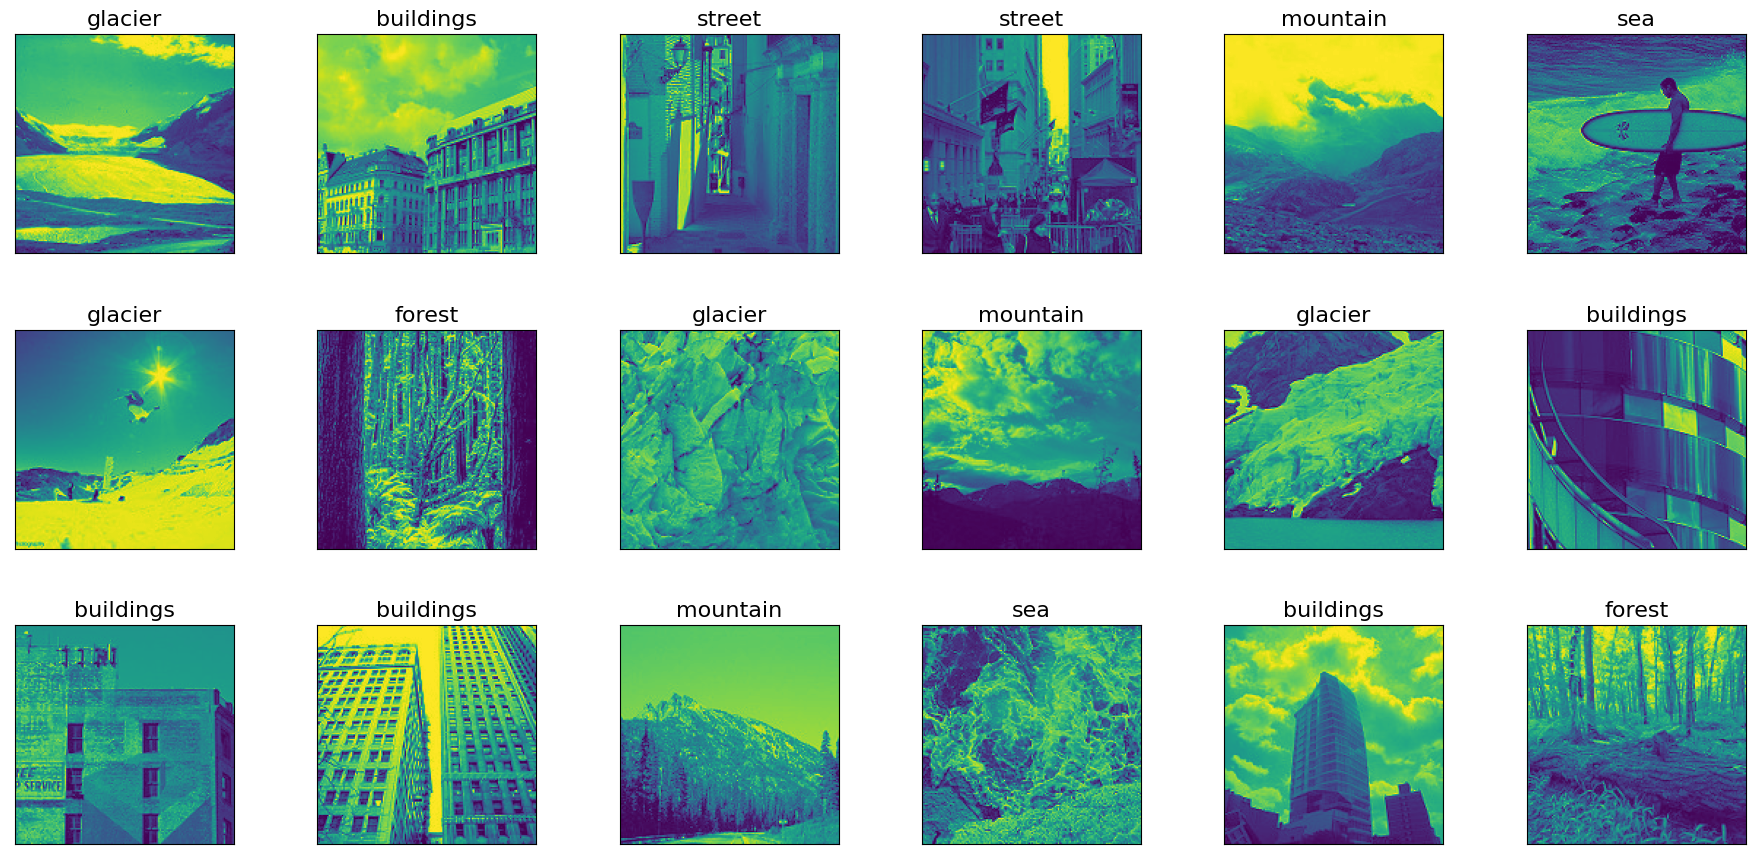

In [57]:
#Plotting some of the training data
print("Some of the training data:")
plot_gallery(X_train, y_train)

Some of the testing data:


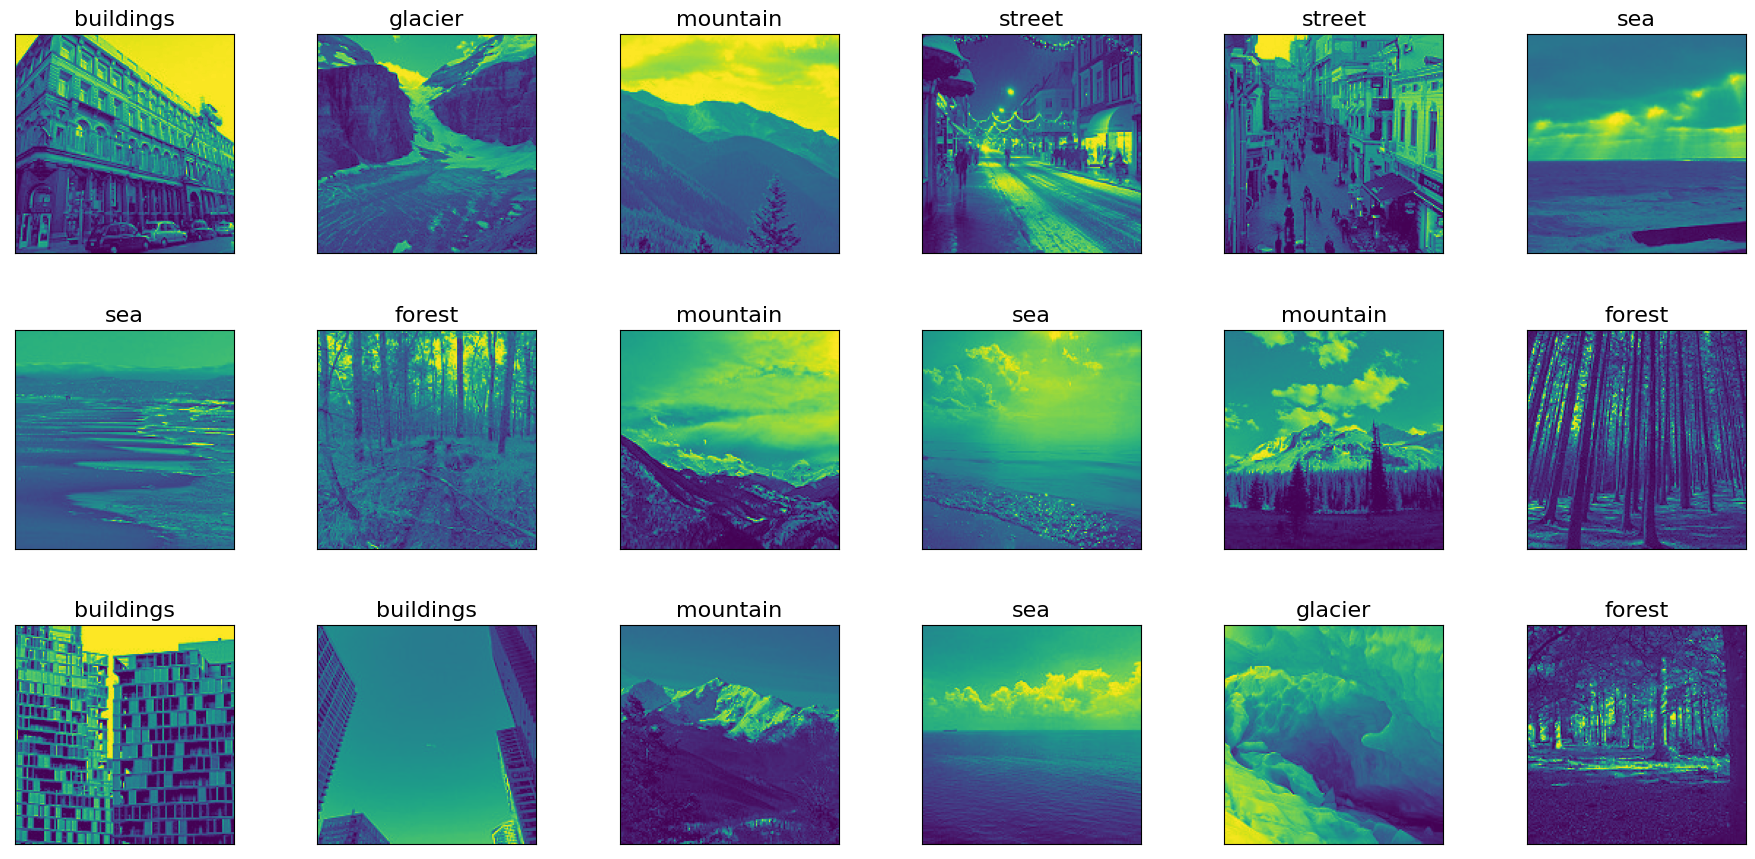

In [58]:
#Plotting some of the testing data
print("Some of the testing data:")
plot_gallery(X_test, y_test)

## Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

Third parties (like image search engines) would be really interested in our algorithm to be able to initially have a classifier that tells them whether a provided image falls under one of the 6 categories. The number of categories can also be expanded by including images from other classes and make the prediction task more and more inclusive of more relevant third parties. This data is really important because it is through which the machine can learn the different ways the image of a certain category can exist, the number of ways the pictures are taken, the different types of (buildings, forests, ...etc!) included can be very helpful in having a very powerful algorithm that can capture even the most unclear building/forests/..etc! image. Therefore, the sole judge of the efficiency of our algorithm is whether it well be able to predict data's classes with hidden labels correctly or not, and to which extent, of course, having the maximum efficiency in this regard is what only can be considered as a useful algorithm for third parties. Thus, an algorithm that predicts the correct label 80% of the time is always better than one that does it 60% of the time, and so on. Moreover, having a false positive or a false negative is equally unfavorable. Consequently, this is probably one of the rare casese when "accuracy" will be considered a good performance metric for our purposes.

## Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

In [59]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5]),
 array([2191, 2271, 2404, 2512, 2274, 2382], dtype=int64))

Looking into the number of instances in the training set (14034 instances) and their distribution among different classes, we can see that there is no drastic difference between the number of each class compared to the others, more or less, they all exist in the same ratio. Thus, since we have the nearly-balanced data, we might be compelled to use shuffle splits with less number of splits than 10 to be more computationally efficient. However, we also need the splits to be stratified to make sure we are mirorring the shape of the original training set. Thus, we decide to go on with using sklearn's StratifiedShuffleSplit.

In [60]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
print(sss)

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.5,
            train_size=None)


# Modeling

## Setup the training to use data expansion in Keras. Explain why the chosen data expansion techniques are appropriate for your dataset. You can use the keras fit generator as a pre-processing step OR in the optimization loop.

In [61]:
"""Importing the needed packages for this part"""
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import average 
from tensorflow.keras.models import  Model
from sklearn import metrics as mt
from skimage.io import imshow
import struct
import seaborn as sns
%matplotlib inline

In [62]:
"""Inspired by the professor's notebook"""
#fixing the sizes, channels last
X_train = np.expand_dims(X_train.reshape((-1,img_wh,img_wh)), axis=3)
X_test = np.expand_dims(X_test.reshape((-1,img_wh,img_wh)), axis=3)
# the image data has been resized to (samples,image_rows,image_cols,image_channels)

# and one hot encoding the output values
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

print('New Shape: Rows: %d, image size: (%d,%d,%d)' % (X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3] ))


New Shape: Rows: 14034, image size: (150,150,1)


(14034, 150, 150, 1)


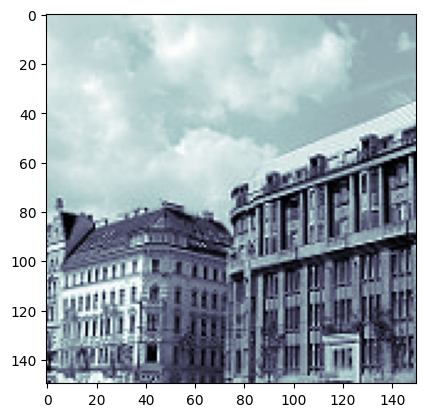

In [63]:
#Visualizing an example output
print(X_train.shape)
plt.subplot(1,1,1)
plt.imshow(X_train[1].squeeze(),cmap='bone')
plt.show()

In [64]:
#Defining the image data generator
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None)

datagen.fit(X_train)

C:\Users\naimb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


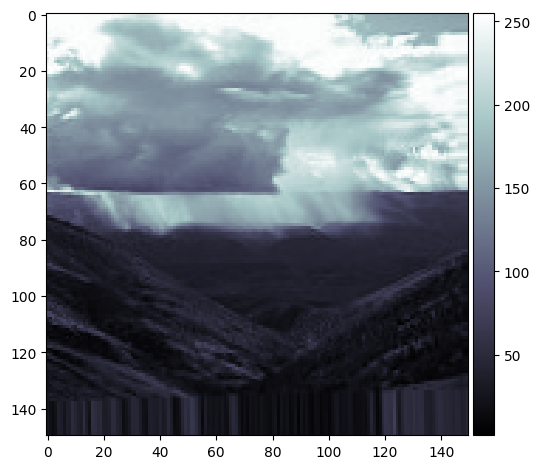

In [65]:
tmps = datagen.flow(X_train, y_train_ohe, batch_size=1)

for tmp in tmps:
    imshow(tmp[0].squeeze(),cmap='bone')
    break

## [2 points] Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture--at minimum have two variations of each network for a total of four models trained). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras). Be sure that models converge. 

In [67]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Reshape, Input
# from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
# from tensorflow.keras.layers import Conv2D, MaxPooling2D
# %%time 

img_wh = 150
cnn = Sequential()

# let's start with an AlexNet style convolutional phase
cnn.add(Conv2D(filters=32,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu', data_format="channels_last")) # more compact syntax

# no max pool before next conv layer!!
cnn.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
    

# add one layer on flattened output
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transformations
cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                   steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                   epochs=5, verbose=1,
                   validation_data=(X_test,y_test_ohe)
)

C:\Users\naimb\AppData\Local\Temp\ipykernel_30692\986290493.py:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128),


Epoch 1/5
109/109 [==============================] - 495s 5s/step - loss: 131.7546 - accuracy: 0.1845 - val_loss: 1.7954 - val_accuracy: 0.1767
Epoch 2/5
109/109 [==============================] - 486s 4s/step - loss: 1.7910 - accuracy: 0.1795 - val_loss: 1.7911 - val_accuracy: 0.1750
Epoch 3/5
109/109 [==============================] - 491s 5s/step - loss: 3.1746 - accuracy: 0.1790 - val_loss: 1.7903 - val_accuracy: 0.1750
Epoch 4/5
109/109 [==============================] - 487s 4s/step - loss: 1.7908 - accuracy: 0.1792 - val_loss: 1.7903 - val_accuracy: 0.1750
Epoch 5/5
109/109 [==============================] - 491s 5s/step - loss: 1.7908 - accuracy: 0.1793 - val_loss: 1.7902 - val_accuracy: 0.1750


94/94 [==============================] - 25s 265ms/step


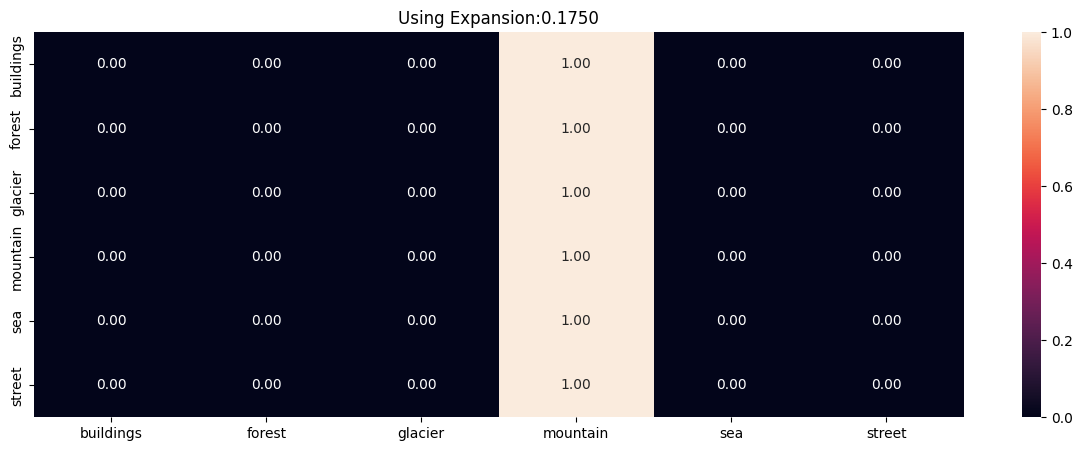

In [68]:
summarize_net(cnn, X_test, y_test, title_text='Using Expansion:')

In [69]:
from tensorflow.keras.layers import Input, average, concatenate
from tensorflow.keras.models import Model
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Reshape, Input
# from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
# from tensorflow.keras.layers import Conv2D, MaxPooling2D

num_ensembles = 3
l2_lambda = 0.000001

input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', data_format="channels_last")(input_holder)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu')(x)
input_conv = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

branches = []
for _ in range(num_ensembles):
    
    # start using NiN (MLPConv)
    x = Conv2D(filters=32,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(input_conv)

    x = Conv2D(filters=32,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    
    x = Conv2D(filters=64,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)

    x = Conv2D(filters=64,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    # add one layer on flattened output
    x = Flatten()(x)
    x = Dropout(0.50)(x) # add some dropout for regularization after conv layers
    x = Dense(64, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
            )(x)
    
    x = Dense(NUM_CLASSES, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
             )(x)
    
    # now add this branch onto the master list
    branches.append(x)

# that's it, we just need to average the results
x = concatenate(branches)

x = Dense(NUM_CLASSES, 
          activation='softmax', 
          kernel_initializer='glorot_uniform',
          kernel_regularizer=l2(l2_lambda)
         )(x)

# here is the secret sauce for setting the network using the 
#   Functional API:
cnn_ens = Model(inputs=input_holder,outputs=x)

cnn_ens.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 150, 150, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_11 (Conv2D)             (None, 150, 150, 32  9248        ['conv2d_10[0][0]']              
                                )                                                             

In [70]:
# Let's train the model 
cnn_ens.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

In [72]:
# the flow method yields batches of images indefinitely, with the given transofmrations
cnn_ens.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                      steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                      epochs=5, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                     )

C:\Users\naimb\AppData\Local\Temp\ipykernel_30692\918246403.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  cnn_ens.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128),


Epoch 1/5
109/109 [==============================] - 510s 5s/step - loss: 1.7927 - accuracy: 0.1790 - val_loss: 1.7921 - val_accuracy: 0.1750
Epoch 2/5
109/109 [==============================] - 510s 5s/step - loss: 1.7927 - accuracy: 0.1786 - val_loss: 1.7920 - val_accuracy: 0.1750
Epoch 3/5
109/109 [==============================] - 513s 5s/step - loss: 1.7926 - accuracy: 0.1788 - val_loss: 1.7921 - val_accuracy: 0.1750
Epoch 4/5
109/109 [==============================] - 513s 5s/step - loss: 1.7927 - accuracy: 0.1791 - val_loss: 1.7921 - val_accuracy: 0.1750
Epoch 5/5
109/109 [==============================] - 514s 5s/step - loss: 1.7926 - accuracy: 0.1792 - val_loss: 1.7920 - val_accuracy: 0.1750


94/94 [==============================] - 26s 271ms/step


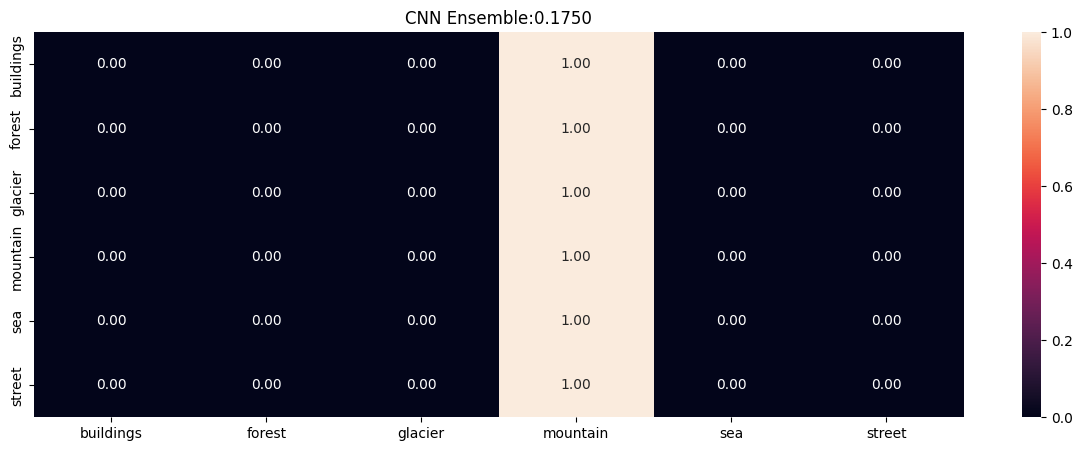

In [73]:
summarize_net(cnn_ens, X_test, y_test, title_text='CNN Ensemble:')

## [1.5 points] Visualize the final results of the CNNs and interpret/compare the performances. 


## [1 points] Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP)  

In [74]:
# make a keras MLP
mlp = Sequential()
mlp.add( Flatten() )
mlp.add( Dense(input_dim=X_train.shape[1], units=100, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=15, 
        shuffle=True, verbose=1)

Epoch 1/15
439/439 [==============================] - 10s 21ms/step - loss: 220.7824 - accuracy: 0.1769
Epoch 2/15
439/439 [==============================] - 9s 21ms/step - loss: 24.4510 - accuracy: 0.1743
Epoch 3/15
439/439 [==============================] - 9s 21ms/step - loss: 3.3409 - accuracy: 0.1711
Epoch 4/15
439/439 [==============================] - 10s 22ms/step - loss: 3.0807 - accuracy: 0.1781
Epoch 5/15
439/439 [==============================] - 9s 22ms/step - loss: 2.9677 - accuracy: 0.1791
Epoch 6/15
439/439 [==============================] - 9s 22ms/step - loss: 2.5819 - accuracy: 0.1792
Epoch 7/15
439/439 [==============================] - 10s 22ms/step - loss: 2.5088 - accuracy: 0.1789
Epoch 8/15
439/439 [==============================] - 9s 22ms/step - loss: 2.2565 - accuracy: 0.1792
Epoch 9/15
439/439 [==============================] - 9s 22ms/step - loss: 2.0398 - accuracy: 0.1791
Epoch 10/15
439/439 [==============================] - 9s 22ms/step - loss: 1.7982 - 

In [75]:
def compare_mlp_cnn(cnn, mlp, X_test, y_test, labels='auto'):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(X_test), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title('MLP: '+str(acc_mlp))

94/94 [==============================] - 1s 5ms/step


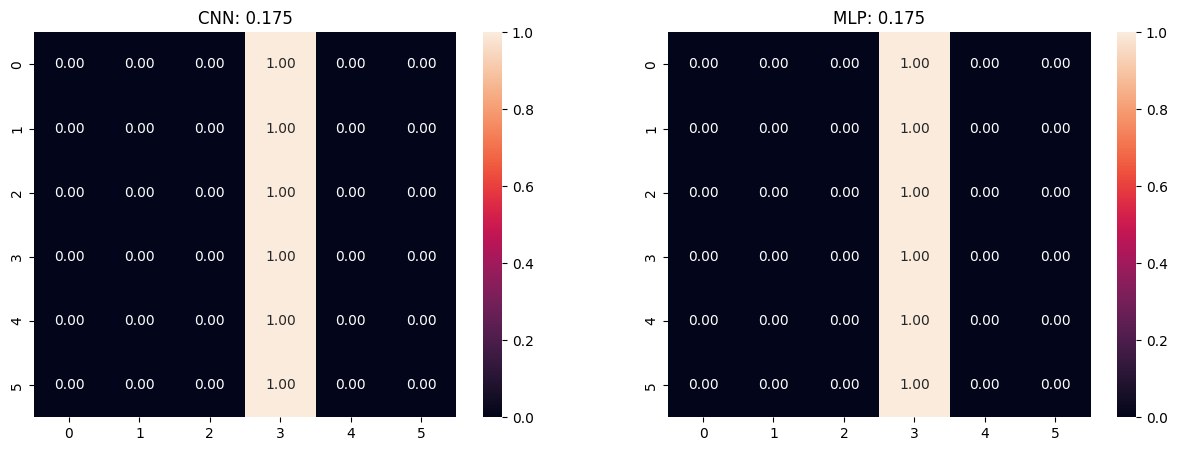

In [76]:
compare_mlp_cnn(cnn,mlp,X_test,y_test)

# Exceptional Work (1 points total)

## You have free reign to provide additional analyses. 

## One idea (required for 7000 level students): Use transfer learning to pre-train the weights of your initial layers of your CNN. Compare the performance when using transfer learning to training without transfer learning (i.e., compare to your best model from above) in terms of classification performance.

In [77]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

NUM_CLASSES = 6
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train_ohe = to_categorical(y_train, NUM_CLASSES)
y_test_ohe = to_categorical(y_test, NUM_CLASSES)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

Exception: URL fetch failure on https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz: None -- [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:997)